In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [9]:
translation_dict = {
    'native-tls-hw-supp': 'Native TLS HW supp',
    'native-tls': 'Native TLS no HW supp',
    'native': 'Native (no TLS)',
    'wasm': 'WASM (no TLS)',
    'wasm-tls': 'WASM TLS',
    'sgx': 'WASM SGX (no TLS)',
    'sgx-tls': 'WASM SGX TLS',
    'sgx-tls-ra': 'WASM SGX TLS Remote Attestation',
    'qos0': 'QoS 0',
    'qos1': 'QoS 1',
    'qos2': 'QoS 2',
    'expected_delivered': 'Expected delivered messages / s',
    'delivered_messages': 'Delivered messages / s',
    'reliability': 'Delivery rate (%)',
    'latency': 'Latency (s)',
    'throughput': 'Throughput (Messages /s) [at min 95 % reliability]',
    'timestamp' : 'Time [s]',
    'messages' : 'Messages / s',
}

cases = ['native-tls', 'native-tls-hw-supp', 'native', 'wasm', 'wasm-tls', 'sgx', 'sgx-tls']
cases_tls = ['native-tls', 'wasm-tls', 'sgx-tls']
cases_no_tls = ['native', 'wasm', 'sgx']
cases_native = ['native-tls', 'native-tls-hw-supp', 'native']

cases = cases_tls

machine = 'grassen-1'

In [10]:
connection_latency_dict = {}
for case in cases:
    df = pd.read_csv('data/' + machine + '/results_' + case + '/latency.csv', sep = ';', names=['timestamp','latency'], dtype = {'timestamp': np.int64, 'latency': np.float64})
    # min_ts = df['timestamp'].min()
    # df['timestamp'] = df['timestamp'] - min_ts

    df = df.sort_values(by=['timestamp'])

    first_ts = df[df['latency'] == -1]
    if len(first_ts) > 0:
        first_ts = first_ts['timestamp'].min()
        df = df[df['timestamp'] < first_ts]
    
    # create datetimelike index based on timestamp
    df.index = pd.to_datetime(df['timestamp'], unit='ms')
    connection_latency_dict[case] = df
    
orchestrator_dict = {}
for case in cases:
    df = pd.read_csv('data/' + machine + '/results_' + case + '/orchestrator.csv', sep = ';')
    orchestrator_dict[case] = df

In [11]:
latency_per_conn_s = {}
interesting_numbers = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
df_latency = pd.DataFrame()
for case in cases:
    df = connection_latency_dict[case]
    df['conn_s'] = 0

    for idx, i in enumerate(interesting_numbers):
        df_orch = orchestrator_dict[case]
        
        df_min_ts = df_orch[df_orch['payload'] == i]

        if not df_min_ts.empty:
            min_ts = df_min_ts['timestamp'].iloc[0]

            if((idx + 1) < len(interesting_numbers)):
                df_max_ts = df_orch[df_orch['payload'] == interesting_numbers[idx + 1]]
            else:
                df_max_ts = df_orch[df_orch['payload'] == 0]
            if df_max_ts.empty:
                max_ts = df['timestamp'].max()
            else:
                max_ts = df_max_ts['timestamp'].iloc[0]
            # how many entries would it have?
            df_count = df.loc[(df['timestamp'] >= min_ts) & (df['timestamp'] < max_ts)]
            if(len(df_count) >= 10 and len(df_count) > 5*i):
                df.loc[(df['timestamp'] >= min_ts) & (df['timestamp'] < max_ts), 'conn_s'] = i

    df = df[df['conn_s'].isin(interesting_numbers)]
    df = df.drop(columns=['timestamp'])
    df_g = df.groupby('conn_s').mean()
    df_g = df_g.reset_index()  

    latency_per_conn_s[case] = df_g

    df['case'] = case
    df_latency = pd.concat([df_latency, df])


In [12]:
latency_per_conn_s_df = pd.DataFrame()
for case in cases:
    df = latency_per_conn_s[case]
    df['case'] = case
    latency_per_conn_s_df = pd.concat([latency_per_conn_s_df, df])

# if directory export does not exist, create it
if not os.path.exists('export'):
    os.makedirs('export')
if not os.path.exists('export/' + machine):
    os.makedirs('export/' + machine)
latency_per_conn_s_df.to_csv('export/' + machine + '/latency_per_conn_s.csv')

# write a description file for the export
# open file "latency_per_conn_s_description.txt" in "write" mode
f = open('export/' + machine + '/latency_per_conn_s_description.txt', 'w')
f.write('This file contains the average latency of a connection given the number of connections / s in milliseconds.\n')
f.write('The first column is a index without any further meaning\n')
f.write('the other columns are as described below:\n\n')
for col in latency_per_conn_s_df.columns:
    if(col == 'case'):
        f.write(col + ': case of the measurement\n')
    if(col == 'latency'):
        f.write(col + ': average latency of a connection given the number of connections / s in milliseconds\n')
    if(col == 'conn_s'):
        f.write(col + ': the number of new connections per second\n')

f.write('\n\n')
f.write('The following cases were measured:\n')
for case in cases:
    f.write(case + ': ' + translation_dict[case] +'\n')

f.close()

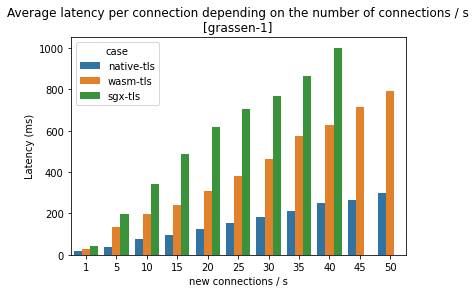

In [13]:
df = latency_per_conn_s_df.rename(columns={'latency': 'Latency (ms)', 'conn_s': 'new connections / s'})
sns.barplot(data=df, x='new connections / s', y='Latency (ms)', hue='case')
plt.title('Average latency per connection depending on the number of connections / s\n['+ machine + ']')
plt.xlabel('new connections / s')
plt.ylabel('Latency (ms)')

plt.savefig('export/' + machine + '/latency_per_conn_s.png', dpi=300, bbox_inches='tight', transparent = False)

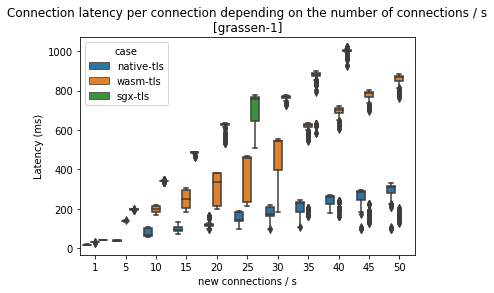

In [14]:
sns.boxplot(data=df_latency, x='conn_s', y='latency', hue='case')
plt.title('Connection latency per connection depending on the number of connections / s\n['+ machine + ']')
plt.xlabel('new connections / s')
plt.ylabel('Latency (ms)')

plt.savefig('export/' + machine + '/latency_per_conn_s_whisker.png', dpi=300, bbox_inches='tight', transparent = False)